In [2]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path
from dateutil.relativedelta import relativedelta
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Masking
from tensorflow.keras.models import Model
from tqdm.keras import TqdmCallback

2023-07-20 17:01:14.795075: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-20 17:01:14.845689: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-20 17:01:14.846945: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 17:01:15.636944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [25]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/minh-notebooks/demonstrated data/final-sample-appending.zarr', consolidated=True)
zarr_ds_sorted = zarr_ds.sortby('time')
zarr_ds_sorted

<xarray.Dataset>
Dimensions:          (time: 3287, lat: 81, lon: 81)
Coordinates:
  * lat              (lat) float32 25.0 24.75 24.5 24.25 ... 5.75 5.5 5.25 5.0
  * lon              (lon) float32 60.0 60.25 60.5 60.75 ... 79.5 79.75 80.0
  * time             (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2001-12-31
Data variables: (12/14)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    direction        (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    sla              (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    ...               ...
    u_curr           (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    u_wind           (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(69, 81, 81), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-11-11
    geospatial_lat_max:         25.0
    geospatial_lat_min:         5.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     OSCAR, ERA5 Reanalysis, Copernicus Climate Ch...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2002-12-31T23:59:59
    time_coverage_start:        2000-01-01T00:00:00
    title:                      Sample of Climate Data for Coastal Upwelling ...

In [28]:
zarr_new = zarr_ds_sorted.sel(lat=slice(35, -5), lon=slice(45,90))
zarr_new.direction.sel(time='1993-09-06').values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [13]:
date_range = pd.date_range(start='1993-01-01', end='2001-12-31')

zarr_dates = pd.to_datetime(zarr_new.time.values)

# times we don't have labels
skip_ranges = [pd.date_range(start='1997-02-01', end='1997-02-28'), 
              pd.date_range(start='2001-11-01', end='2001-11-30')]

sst_data = []
for date in date_range:
    if any(date in skip_range for skip_range in skip_ranges):
        continue
    if date in zarr_dates:
        sst_data.append(zarr_new.direction.sel(time=str(date.date())).values)

normalized_data = []
for day_data in sst_data:
    mean_val = np.nanmean(day_data)
    normalized_day_data = day_data - mean_val
    normalized_data.append(normalized_day_data)

normalized_data_array = np.array(normalized_data)

processed_data = np.nan_to_num(normalized_data_array, nan=0.0)

In [15]:
# Create a new date range without skip_ranges
filtered_date_range = date_range[~date_range.isin([date for skip_range in skip_ranges for date in skip_range])]

normalized_data = []
days_with_only_nan = []

for date, day_data in zip(filtered_date_range, sst_data):
    if np.all(np.isnan(day_data)):
        mean_val = 0
        days_with_only_nan.append(date)
    else:
        mean_val = np.nanmean(day_data)
        
    normalized_day_data = day_data - mean_val
    normalized_data.append(normalized_day_data)

# print the dates where we got all NaNs
if days_with_only_nan:
    print("The following dates have data that are completely NaN:")
    for day in days_with_only_nan:
        print(day.date())


The following dates have data that are completely NaN:
1993-03-11
1993-03-12
1993-03-13
1993-03-14
1993-03-15
1993-03-16
1993-03-17
1993-03-18
1993-03-19
1993-03-20
1993-03-21
1993-03-22
1993-03-23
1993-03-24
1993-03-25
1993-03-26
1993-03-27
1993-03-28
1993-03-29
1993-03-30
1993-03-31
1993-04-01
1993-04-02
1993-04-03
1993-04-04
1993-04-05
1993-04-06
1993-04-07
1993-04-08
1993-04-09
1993-04-10
1993-07-20
1993-07-21
1993-07-22
1993-07-23
1993-07-24
1993-07-25
1993-07-26
1993-07-27
1993-07-28
1993-07-29
1993-07-30
1993-07-31
1993-08-01
1993-08-02
1993-08-03
1993-08-04
1993-08-05
1993-08-06
1993-08-07
1993-08-08
1993-08-09
1993-08-10
1993-08-11
1993-08-12
1993-08-13
1993-08-14
1993-08-15
1993-08-16
1993-08-17
1993-08-18
1993-08-19
1993-08-20
1993-08-21
1993-08-22
1993-08-23
1993-08-24
1993-08-25
1993-08-26
1993-08-27
1993-08-28
1993-08-29
1993-08-30
1993-08-31
1993-09-01
1993-09-02
1993-09-03
1993-09-04
1993-09-05
1993-09-06
1993-09-07
1993-09-08
1993-09-09
1993-09-10
1993-09-11
1993-09-12

In [84]:
date_range = pd.date_range(start='1993-01-01', end='2001-12-31')
zarr_dates = pd.to_datetime(zarr_new.time.values)

# times we don't have labels
skip_ranges = [
    pd.date_range(start='1997-02-01', end='1997-02-28'),
    pd.date_range(start='2001-11-01', end='2001-11-30')
]

date_to_data_map = {}

for date in date_range:
    if any(date in skip_range for skip_range in skip_ranges):
        continue
    if date in zarr_dates:
        data = zarr_new.direction.sel(time=str(date.date())).values
        if not np.all(np.isnan(data)): 
            mean_val = np.nanmean(data) if not np.all(np.isnan(data)) else 0.0
            normalized_day_data = data - mean_val
            normalized_day_data = np.nan_to_num(normalized_day_data, nan=0.0)
            
            date_to_data_map[date] = normalized_day_data


In [68]:
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path
from dateutil.relativedelta import relativedelta

def get_labels(start_date, end_date):
    # Convert input dates to datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # List to store all group labels
    all_labels = pd.Series(dtype=int)

    # Initialize current date to start_date
    curr_date = start_date

    while curr_date <= end_date:
        year = curr_date.year
        month = curr_date.month
        
        file_name = f"/home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            curr_date += relativedelta(months=1)
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22 and 23, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])

        # Move to the next month
        curr_date += relativedelta(months=1)

    print(all_labels.shape)
    return all_labels

# Call the function with your specific start and end date
labels = get_labels('1993-01-01', '2001-12-31')

Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199301_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199302_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199303_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199304_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199305_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199306_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199307_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199308_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199309_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/199310_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0

In [88]:
valid_dates = list(date_to_data_map.keys())
filtered_labels = labels[labels.index.isin(valid_dates)]
filtered_labels.shape

(2428,)

In [90]:
all_labels_reshaped = filtered_labels.values.ravel()

In [99]:
X = np.array(list(date_to_data_map.values()))

X = np.expand_dims(X, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(X, all_labels_reshaped, test_size=0.2, random_state=42)

In [100]:
# Define the model
base_model = EfficientNetB0(include_top=False, weights=None, input_shape=(processed_data.shape[1], processed_data.shape[2], 1))

In [101]:
# Add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# And a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tqdm_callback = TqdmCallback(verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[tqdm_callback])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

16/16 [==============================] - 2s 66ms/step - loss: 0.2307 - accuracy: 0.9506
Accuracy: 0.9506173133850098


In [103]:
data = []  # List to store each row of the DataFrame

# Iterate through all dates in date_to_data_map
for date, day_data in date_to_data_map.items():
    actual_val = filtered_labels[date]

    # Pre-process the day data and predict
    day_data = np.nan_to_num(day_data, nan=0.0)  # Replace NaN with 0
    day_data = np.expand_dims(day_data, axis=(0, -1))  # Add a new dimension for the batch and channel

    prediction = model.predict(day_data)

    # Append the data for the current date to the list
    data.append({'time': date, 'actual_val': actual_val, 'predicted_val': prediction[0][0]})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Check the DataFrame
print(df)


1/1 [==============================] - 0s 27ms/step
           time  actual_val  predicted_val
0    1993-01-01           0       0.000006
1    1993-01-02           0       0.000005
2    1993-01-03           0       0.000005
3    1993-01-04           0       0.000017
4    1993-01-05           0       0.000005
...         ...         ...            ...
2423 2001-10-27           0       0.000009
2424 2001-10-28           0       0.000010
2425 2001-10-29           0       0.000030
2426 2001-10-30           0       0.000013
2427 2001-10-31           0       0.000022

[2428 rows x 3 columns]


In [107]:
print(len(df[(df['actual_val'] == 0) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 0)]))
print(len(df[(df['actual_val'] == 1) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 1)]))

12
2176
240
252


/tmp/ipykernel_45/736422993.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
/tmp/ipykernel_45/736422993.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1')


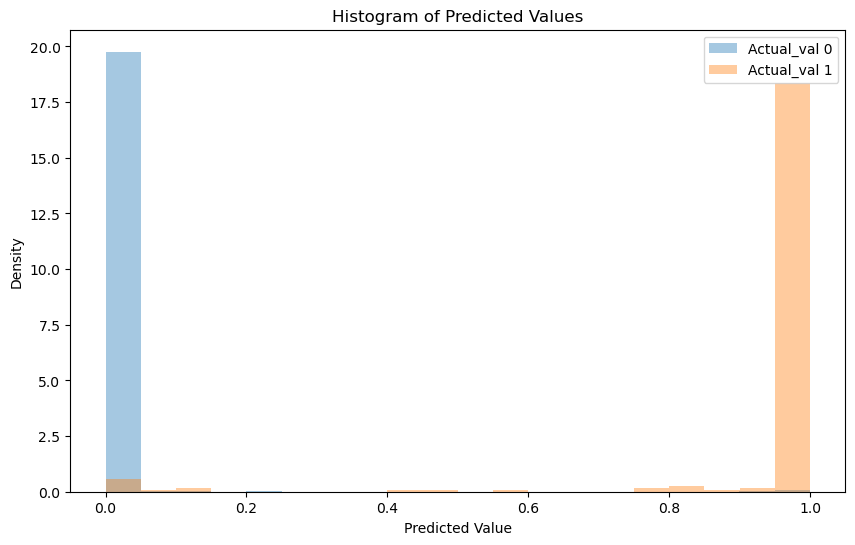

In [106]:
import seaborn as sns
from matplotlib import pyplot as plt
# Convert 'predicted_val' to float
df['predicted_val'] = df['predicted_val'].apply(lambda x: float(x[0]) if isinstance(x, (list, np.ndarray)) else float(x))

# Separate the data into two groups based on 'actual_val'
group0 = df[df['actual_val'] == 0]['predicted_val']
group1 = df[df['actual_val'] == 1]['predicted_val']

# Create the histogram plot
plt.figure(figsize=(10, 6))
sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1')

# Set the labels and title
plt.xlabel('Predicted Value')
plt.ylabel('Density')
plt.title('Histogram of Predicted Values')
plt.legend()

# Show the plot
plt.show()